In [65]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import IsolationForest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    make_scorer  # Imported make_scorer
)
import matplotlib.pyplot as plt
import seaborn as sns




In [66]:
df = pd.read_csv('training.csv')
df

,hour_of_day,day_of_week,month,holiday,weekday,summertime,temp,dew,humidity,precip,snow,snowdepth,windspeed,cloudcover,visibility,increase_stock
0,5,5,1,0,0,0,-7.2,-15.0,53.68,0.000,0,0.0,16.3,31.6,16.0,low_bike_demand
1,21,4,1,0,1,0,-1.3,-12.8,40.97,0.000,0,0.0,23.9,85.7,16.0,low_bike_demand
2,21,3,8,0,1,1,26.9,21.8,73.39,0.000,0,0.0,0.0,81.1,16.0,low_bike_demand
3,1,6,1,0,0,0,3.1,-4.0,59.74,0.000,0,0.0,19.2,0.0,16.0,low_bike_demand
4,17,0,3,0,1,0,11.7,-11.4,18.71,0.000,0,0.0,10.5,44.6,16.0,low_bike_demand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,3,5,6,0,0,1,21.5,19.4,87.68,0.000,0,0.0,10.6,24.4,16.0,low_bike_demand
1596,14,0,6,0,1,1,23.2,20.1,82.43,2.217,0,0.0,9.8,92.1,10.4,low_bike_demand
1597,13,0,3,0,1,1,13.9,-2.2,32.93,0.000,0,2.0,18.2,79.3,16.0,low_bike_demand
1598,14,5,3,0,0,1,11.7,-9.3,22.09,0.000,0,0.0,5.8,24.4,16.0,high_bike_demand


In [67]:
df.size

25600

In [68]:
# 1. Handle Missing Values
missing_values = df.isnull().sum()
print("Missing Values in Each Column:")
print(missing_values)

Missing Values in Each Column:
hour_of_day       0
day_of_week       0
month             0
holiday           0
weekday           0
summertime        0
temp              0
dew               0
humidity          0
precip            0
snow              0
snowdepth         0
windspeed         0
cloudcover        0
visibility        0
increase_stock    0
dtype: int64


In [69]:
# 2. Handle Target Variable Encoding
df['increase_stock'] = df['increase_stock'].map({'low_bike_demand': 0, 'high_bike_demand': 1})

# Cyclic encoding for 'hour_of_day', 'day_of_week', and 'month'
df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hour_of_day     1600 non-null   int64  
 1   day_of_week     1600 non-null   int64  
 2   month           1600 non-null   int64  
 3   holiday         1600 non-null   int64  
 4   weekday         1600 non-null   int64  
 5   summertime      1600 non-null   int64  
 6   temp            1600 non-null   float64
 7   dew             1600 non-null   float64
 8   humidity        1600 non-null   float64
 9   precip          1600 non-null   float64
 10  snow            1600 non-null   int64  
 11  snowdepth       1600 non-null   float64
 12  windspeed       1600 non-null   float64
 13  cloudcover      1600 non-null   float64
 14  visibility      1600 non-null   float64
 15  increase_stock  1600 non-null   int64  
 16  hour_sin        1600 non-null   float64
 17  hour_cos        1600 non-null   f

In [70]:
# 3. Handling Outliers using Isolation Forest (for highly skewed variables)
features = ['precip', 'snowdepth', 'visibility']
X = df[features]

iso_forest = IsolationForest(contamination=0.05)  # Set the contamination based on data
outliers = iso_forest.fit_predict(X)

df['outlier'] = np.where(outliers == -1, 1, 0)
df = df[df['outlier'] == 0]


In [71]:
# 4. Handle Multicollinearity using VIF
features_for_vif = df.select_dtypes(include=[np.number]).drop(columns=['increase_stock', 'outlier'])

vif_data = pd.DataFrame()
vif_data['Feature'] = features_for_vif.columns
vif_data['VIF'] = [variance_inflation_factor(features_for_vif.values, i) for i in range(len(features_for_vif.columns))]

high_vif_features = vif_data[vif_data['VIF'] > 10]
print("Features with High VIF (>10):")
print(high_vif_features)


"""
# Apply PCA to reduce features with high multicollinearity
# Keep the features that were not flagged for high VIF
features_for_pca = features_for_vif.drop(columns=high_vif_features['Feature'])

# Standardize the data before PCA
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_pca)

# Apply PCA
pca = PCA(n_components=0.95)  # Keeps 95% of the variance
pca_features = pca.fit_transform(scaled_features)

# Add the PCA-transformed features back to the dataframe
df_pca = pd.DataFrame(pca_features, columns=[f'PCA_{i+1}' for i in range(pca_features.shape[1])])
df = pd.concat([df, df_pca], axis=1)

# Optionally drop the original features that were replaced by PCA
df = df.drop(columns=features_for_pca.columns)
"""

# Display the updated DataFrame with PCA components
print(df.head())



Features with High VIF (>10):
        Feature         VIF
1   day_of_week   26.513238
2         month   12.882700
4       weekday   26.872352
6          temp  116.010783
7           dew   65.045949
8      humidity  100.745493
14   visibility  123.710210
   hour_of_day  day_of_week  month  holiday  weekday  summertime  temp   dew  \
0            5            5      1        0        0           0  -7.2 -15.0   
1           21            4      1        0        1           0  -1.3 -12.8   
2           21            3      8        0        1           1  26.9  21.8   
3            1            6      1        0        0           0   3.1  -4.0   
4           17            0      3        0        1           0  11.7 -11.4   

   humidity  precip  ...  cloudcover  visibility  increase_stock  hour_sin  \
0     53.68     0.0  ...        31.6        16.0               0  0.965926   
1     40.97     0.0  ...        85.7        16.0               0 -0.707107   
2     73.39     0.0  ...       

/Users/abhinavramalingam/Documents/Uppsala/SML/.conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


In [72]:
# 5. Split the dataset into training, testing, and validation sets using seed=32 and train_test_split
df = df.dropna()
X = df.drop(columns=['increase_stock', 'outlier'])
y = df['increase_stock']

# Split the dataset into training and testing sets (80%-20%) with random_state=32 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32, stratify=y)


In [73]:
# 6. Train the Model
knn = KNeighborsClassifier()

# GridSearchCV with hyperparameters to be tuned
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# GridSearchCV for model tuning with 5-fold cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='precision', verbose=1)
grid_search.fit(X_train, y_train)  # Using X_train after scaling

# Output the best hyperparameters from GridSearchCV
print("Best Hyperparameters from GridSearchCV:")
print(grid_search.best_params_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters from GridSearchCV:
{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}



Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       247
           1       0.61      0.58      0.59        57

    accuracy                           0.85       304
   macro avg       0.76      0.75      0.75       304
weighted avg       0.85      0.85      0.85       304



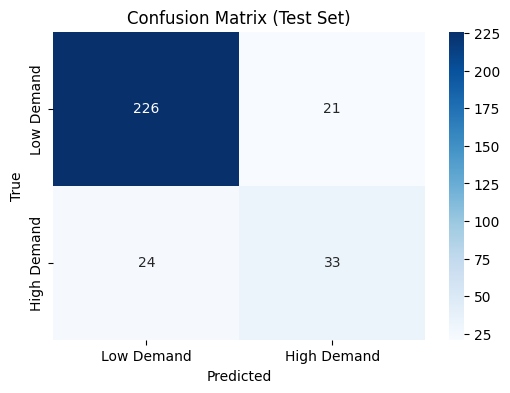

In [74]:
# 7. Evaluate the Model
best_knn = grid_search.best_estimator_

y_test_pred = best_knn.predict(X_test) 

print("\nClassification Report (Test Set):") 
print(classification_report(y_test, y_test_pred))

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Demand', 'High Demand'], yticklabels=['Low Demand', 'High Demand'])
plt.title('Confusion Matrix (Test Set)')  
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


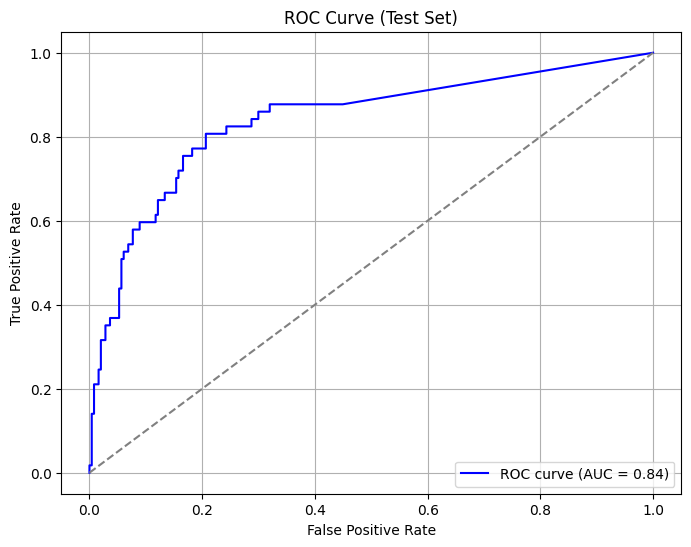

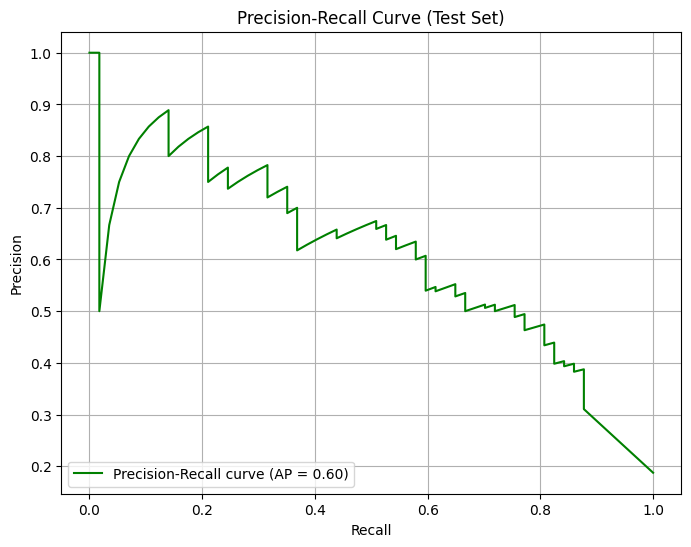

In [75]:
# 8. Plot ROC Curve and Precision-Recall Curve for our prediction

# Predict probabilities for the test set
y_test_prob = best_knn.predict_proba(X_test)[:, 1]  # changed to X_test (no scaling applied)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
plt.title('ROC Curve (Test Set)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
avg_precision = average_precision_score(y_test, y_test_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.title('Precision-Recall Curve (Test Set)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
